# Injecting signals with a pre-determined SNR
This tutorial walks through created injected signals with a target signal-to-noise ratio (SNR).

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. Once you have CuPy installed, to enable GPU acceleration you must set `SETIGEN_ENABLE_GPU` to '1' in the shell or in Python via `os.environ`. It can also be useful to set `CUDA_VISIBLE_DEVICES` to specify which GPUs to use.

In [1]:
# !pip install cupy-cuda110

In [2]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, "../../")
import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [4]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

Creating the backend elements:

In [5]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

Initializing the antenna and backend:

In [6]:
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

We can now add noise to each polarization:

In [7]:
for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=1)

## Calculating signal levels

Now, to add a signal at a target SNR in finely channelized data products, we need to use the correct amplitude for the cosine signal at the antenna level. 

There are a few things to keep in mind here. First, since the filterbank data products are powers, the final signal strength goes as the square of the initial amplitude (e.g. `level`). Then, there are scaling factors due to the rFFT in the polyphase filterbank and the FFT in the fine channelization step. If there is a time integration, that must be accounted for in the initial amplitude. Most of these effects are calculated using `stg.voltage.get_level`:

In [8]:
fftlength = 1024
num_blocks = 1

signal_level = stg.voltage.get_level(snr=10, 
                                     raw_voltage_backend=rvb,
                                     fftlength=fftlength,
                                     num_blocks=num_blocks,
                                     length_mode='num_blocks')
signal_level

0.0010918300671385692

Note that the `RawVoltageBackend` is a parameter to this function, since it uses information like the sample rate, recorded data size, etc. The function operates in two `length_mode`'s, `'obs_length'` and `'num_blocks'`, similar to the `RawVoltageBackend.record()` function. Finally, specify the SNR you'd like the signal to have at the very end.

This function will generate the correct cosine amplitude at the `Antenna` level to achieve the desired SNR if the initial real Gaussian noise has a variance of 1, the signal is non-drifting, and the signal frequency is centered on a spectral bin after fine channelization. Of course, rarely in reality are all of these satisfied, if ever!

### Corrective factors

If the signal is non-drifting, in general the spectral response will go as `1/sinc^2(x)`, where `x` is the fractional error off of the center of the spectral bin. To calculate the corresponding amount to adjust `signal_level`, you can use `stg.voltage.get_leakage_factor(f_start, raw_voltage_backend, fftlength)`. This technically calculates `1/sinc(x)`, which is inherently squared naturally along with the cosine signal amplitude during fine channelization.

To account for the noise, for any given data stream, you can get the noise level using `stream.get_total_noise_std()`. This method will also work for data streams within `Antenna`'s that are part of `MultiAntennaArray`'s, specifically that it will automatically account for the background noise in the array. Since the noise power is squared during fine channelization, the signal amplitude should go linearly as a function of the standard deviation of the noise.

To account for drift rates, it gets a bit more complicated; in general, if the drift rate is larger than a pixel by pixel slope of 1 in the final spectrogram data products, dividing the initial non-drifting power by that pixel by pixel slope will result in the new power. In other words, if `s` is the drift rate corresponding to a final pixel by pixel slope of 1, then a signal drifing by `+-2s` will have half the SNR of the non-drifting signal. For a given `RawVoltageBackend` and reduced data product parameters `fftlength` and `int_factor` (integration factor), you can calculate `s` via `stg.voltage.get_unit_drift_rate(raw_voltage_backend, fftlength, int_factor)`. However, the situation is much more complicated for drift rates between 0 and `s`, so `setigen` doesn't currently automatically calculate the requisite shift in power. Note that if you'd like to adjust the power for drift rates higher than `s`, you should adjust the amplitude (level) of the cosine signal by the *square root* of the relevant factor.

While one can try to account for all of these elements, bear in mind that there is random noise in the real voltage stage, which can be amplified and cause deviations in the final reported SNR!

In [9]:
for f_start in np.linspace(6003.1e6, 6003.9e6, 9):
    leakage_factor = stg.voltage.get_leakage_factor(f_start, rvb, fftlength)
    print(f'{f_start/1e6:.4f} MHz leakage factor: {leakage_factor:.3f}')
    
    for stream in antenna.streams:
        level = stream.get_total_noise_std() * leakage_factor * signal_level
        stream.add_constant_signal(f_start=f_start, 
                                   drift_rate=0*u.Hz/u.s, 
                                   level=level)


6003.1000 MHz leakage factor: 1.487
6003.2000 MHz leakage factor: 1.514
6003.3000 MHz leakage factor: 1.392
6003.4000 MHz leakage factor: 1.295
6003.5000 MHz leakage factor: 1.217
6003.6000 MHz leakage factor: 1.154
6003.7000 MHz leakage factor: 1.105
6003.8000 MHz leakage factor: 1.066
6003.9000 MHz leakage factor: 1.037


## Recording synthetic data
Now that we have all the pieces of the backend created, we can now create GUPPI RAW files using `RawVoltageBackend.record()`. There are two modes to record, `num_blocks` and `obs_length`. The former allows you to specify how many data blocks to record, as defined by the RAW format, and the latter computes the number of required blocks from the desired observation length (in seconds). The `header_dict` parameter allows for overwriting existing header values / adding additional keywords. For example, TurboSETI requires the `TELESCOP` parameter to be set to "GBT" to run on certain types of RAW files, so you can overwrite this parameter using `header_dict`.

`raw_file_stem` is the path + prefix for your saved GUPPI RAW file.

In [10]:
rvb.record(raw_file_stem='example_snr',
           num_blocks=num_blocks, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

Blocks: 100%|██████████| 1/1 [00:14<00:00, 14.09s/it]     


## Taking a look
If `rawspec` is installed, you can unpack the data as such:

In [11]:
!rawspec -f 1024 -t 4 -d . example_snr

working stem: example_snr
opening file: example_snr.0000.raw
got error cudaErrorMemoryAllocation at rawspec_gpu.cu:541
rawspec initialization failed
output product 0: 0 spectra


Using `blimpy` to open the resulting filterbank file and plotting the data:

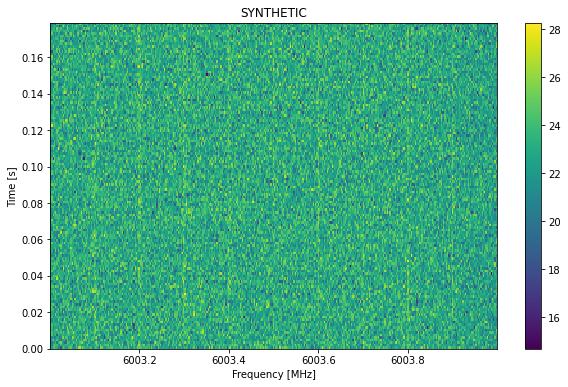

In [12]:
wf = bl.Waterfall('example_snr.rawspec.0000.fil',
                  f_start=6003.0,
                  f_stop=6004.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

We can use `setigen` to create a `Frame` and quickly plot the spectrum with SNR on the y-axis:

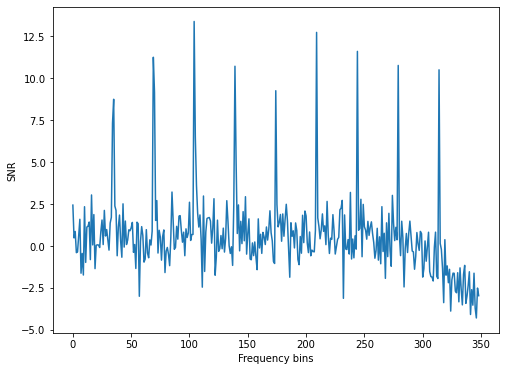

In [13]:
frame = stg.Frame(wf)

spectrum = stg.integrate_frame(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()